The cross shop module calculates the overlap of customers buying or transactions containing 2 to 3 different products
or categories.

A typical use case is to analyze promotion cannibalization, which we will explore below.

### Setup

We'll start by loading some simulated data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_parquet("../../data/transactions.parquet")
df.head()

,transaction_id,transaction_date,transaction_time,customer_id,product_id,product_name,category_0_name,category_0_id,category_1_name,category_1_id,brand_name,brand_id,unit_quantity,unit_cost,unit_spend,store_id
0,16050,2023-01-12,17:44:29,1,15,Spawn Figure,Toys,1,Action Figures,1,McFarlane Toys,3,2,36.10,55.98,6
1,16050,2023-01-12,17:44:29,1,1317,Gone Girl,Books,8,Mystery & Thrillers,53,Alfred A. Knopf,264,1,6.98,10.49,6
2,20090,2023-02-05,09:31:42,1,509,Ryzen 3 3300X,Electronics,3,Computer Components,21,AMD,102,3,200.61,360.00,4
3,20090,2023-02-05,09:31:42,1,735,Linden Wood Paneled Mirror,Home,5,Home Decor,30,Pottery Barn,147,1,379.83,599.00,4
4,20090,2023-02-05,09:31:42,1,1107,Pro-V Daily Moisture Renewal Conditioner,Beauty,7,Hair Care,45,Pantene,222,1,3.32,4.99,4


In [ ]:
print(f"Number of unique customers: {df['customer_id'].nunique()}")
print(f"Number of unique transactions: {df['transaction_id'].nunique()}")

Number of unique customers: 4250
Number of unique transactions: 25490


## Scenario: Jeans or Shoes cross promotion

You are in charge of the Dresses product category for a large department store. You would like to run a targeted 
promotion to attract more dress shoppers and are trying to decide whether to target customers who have bought jeans or 
shoes in the past, but haven't bought Jeans. Your key question is whether a jeans or a Shoes buyer is more likely to 
also purchase dresses?



We'll artifically alter our data set to show that there are more shoe buyers. This is purely 
for the example.

In [ ]:
shoes_idx = df["category_1_name"] == "Shoes"
df.loc[shoes_idx, "category_1_name"] = np.random.RandomState(42).choice(
    ["Shoes", "Jeans"],
    size=shoes_idx.sum(),
    p=[0.5, 0.5],
)

We'll start by looking at the overlap of customer spend. From the graph below you can see that 
21% of customer spend both is on jeans and dresses. This is far higher than the 3.6% of spend shoes and dresses, and the highest of all the combinations. This suggests this is a significant trend.

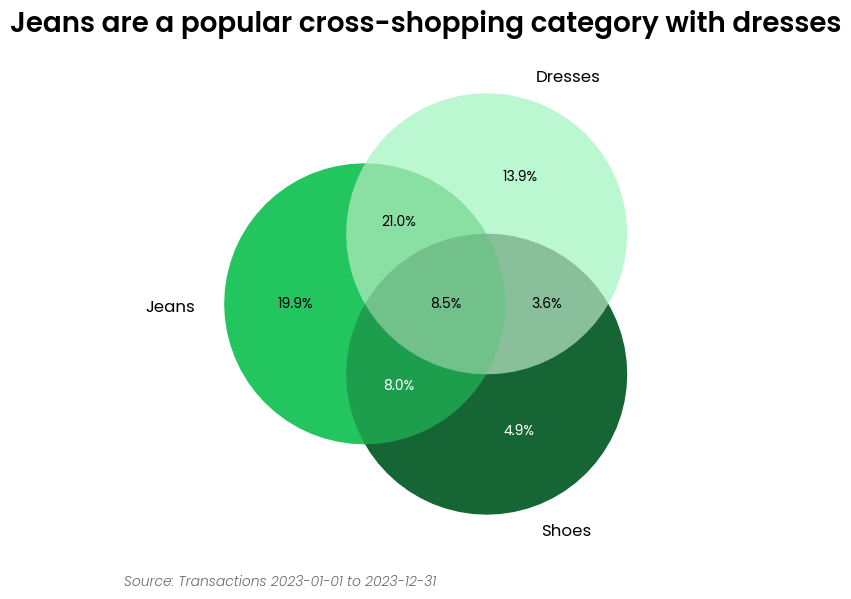

,group_1,group_2,group_3,groups,unit_spend
customer_id,,,,,
1,0,1,0,"(0, 1, 0)",15444.07
2,0,0,0,"(0, 0, 0)",52596.03
3,0,0,0,"(0, 0, 0)",8106.66
4,1,0,1,"(1, 0, 1)",43042.60
5,0,0,0,"(0, 0, 0)",15103.83


,groups,unit_spend,percent
0,"(0, 0, 0)",17955616.81,0.201549
1,"(0, 0, 1)",12340333.28,0.138518
2,"(0, 1, 0)",4403812.22,0.049432
3,"(0, 1, 1)",3241751.96,0.036388
4,"(1, 0, 0)",17722455.78,0.198932
5,"(1, 0, 1)",18695128.69,0.209850
6,"(1, 1, 0)",7162512.42,0.080398
7,"(1, 1, 1)",7566570.23,0.084933


In [ ]:
from pyretailscience.analysis import cross_shop

cs = cross_shop.CrossShop(
    df,
    group_1_col="category_1_name",
    group_1_val="Jeans",
    group_2_col="category_1_name",
    group_2_val="Shoes",
    group_3_col="category_1_name",
    group_3_val="Dresses",
    labels=["Jeans", "Shoes", "Dresses"],
)
cs.plot(
    title="Jeans are a popular cross-shopping category with dresses",
    source_text="Source: Transactions 2023-01-01 to 2023-12-31",
    figsize=(6, 6),
    subset_label_formatter=lambda x: f"{x:.1%}",
)
plt.show()
# Let's see which customers were in which groups
display(cs.cross_shop_df.head())
# And the totals for all groups
display(cs.cross_shop_table_df)

To make this point more dramatic, it's also possible to vary the size of the circles based on the values by setting `vary_sizes` to True when plotting. When we do this you can see that the size of the Shoes circle is much smaller.

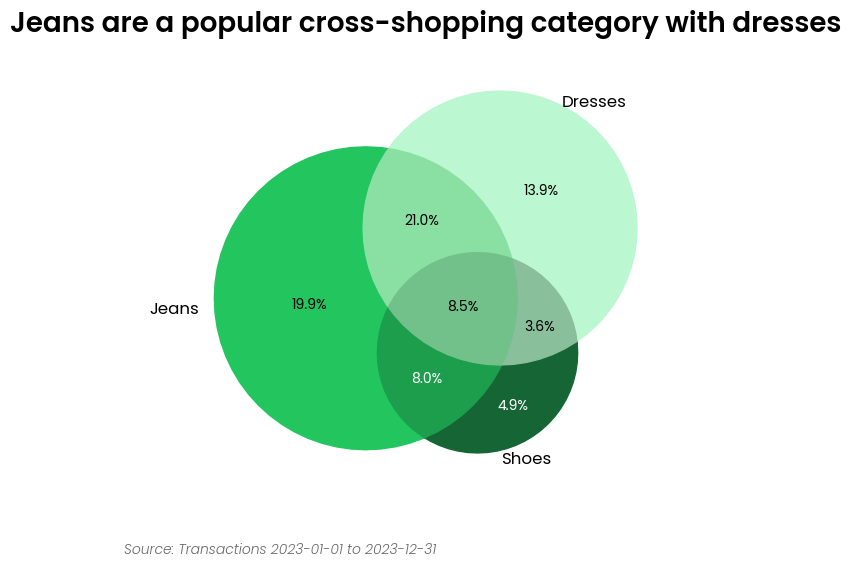

In [ ]:
cs.plot(
    title="Jeans are a popular cross-shopping category with dresses",
    source_text="Source: Transactions 2023-01-01 to 2023-12-31",
    figsize=(6, 6),
    vary_size=True,
    subset_label_formatter=lambda x: f"{x:.1%}",
)
plt.show()

We can back up our first observation by looking at the overlap in customer groups. Here we see that several times as many customers buy both jeans and dresses and shoes and dresses, and that jeans is a much more popular category than shoes. From this simple analysis it seems that jeans would make a much better category for a cross promotion than shoes.

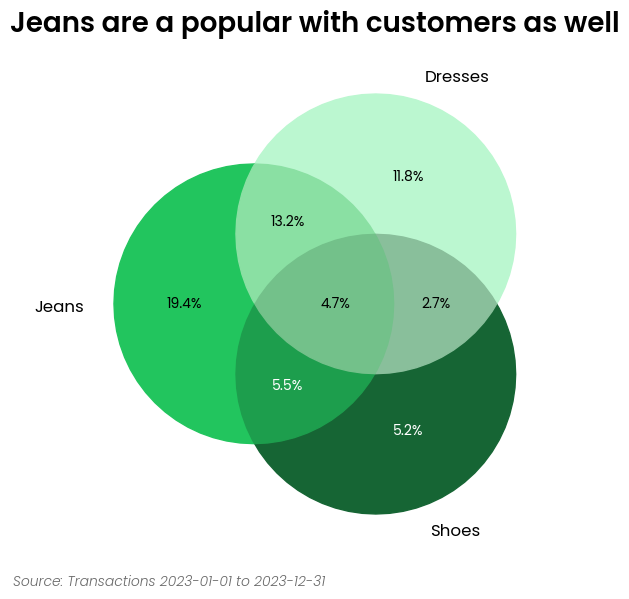

In [ ]:
cs = cross_shop.CrossShop(
    df,
    group_1_col="category_1_name",
    group_1_val="Jeans",
    group_2_col="category_1_name",
    group_2_val="Shoes",
    group_3_col="category_1_name",
    group_3_val="Dresses",
    labels=["Jeans", "Shoes", "Dresses"],
    value_col="customer_id",
    agg_func="nunique",
)
cs.plot(
    title="Jeans are a popular with customers as well",
    source_text="Source: Transactions 2023-01-01 to 2023-12-31",
    figsize=(6, 6),
    subset_label_formatter=lambda x: f"{x:.1%}",
)
plt.show()